In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
titanic_data = pd.read_csv('./train.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


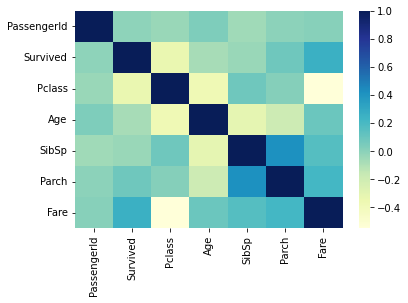

In [3]:
import seaborn as sb

sb.heatmap(titanic_data.corr(), cmap="YlGnBu")
plt.show()

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Split the train data to have some test data, but maintain good proportion of info about Survived, Pclass and Sex in both (if not, in the test it can be bad)
for train_indices, test_indices in splitter.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

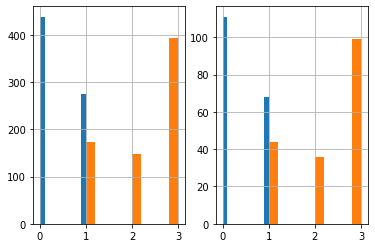

In [5]:
plt.subplot(1, 2, 1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1, 2, 2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()

In [6]:
# We have some missing data, like age, how to solve?
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 629 to 7
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        156 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# To solve the missing ages, we will estimate the missing values using the mean of ages
class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        imputer = SimpleImputer(strategy="mean")
        x["Age"] = imputer.fit_transform(x[["Age"]])
        return x

In [10]:
# Using HotEncoder to transform the Embarked column to three binary columns (C, S and Q with values 0 or 1) and the Sex column into two binary columns (Female and Male)
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        encoder = OneHotEncoder()

        matrix = encoder.fit_transform(x[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"]
        for i in range(len(matrix.T)):
            x[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(x[["Sex"]]).toarray()
        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            x[column_names[i]] = matrix.T[i]

        return x

In [15]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    # Some columns as Name, Ticket and Cabin can have some correlation with the Survived rates, but this correlation is best defined by the Fare column
    def transform(self, x):
        return x.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [16]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [17]:
# Runs the transform method of all the classes of the pipeline
strat_train_set = pipeline.fit_transform(strat_train_set)
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
629,630,0,3,29.115993,0,0,7.7333,0.0,1.0,0.0,0.0,1.0
633,634,0,1,29.115993,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
364,365,0,3,29.115993,1,0,15.5000,0.0,1.0,0.0,0.0,1.0
632,633,1,1,32.000000,0,0,30.5000,1.0,0.0,0.0,0.0,1.0
97,98,1,1,23.000000,0,1,63.3583,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
451,452,0,3,29.115993,1,0,19.9667,0.0,0.0,1.0,0.0,1.0
706,707,1,2,45.000000,0,0,13.5000,0.0,0.0,1.0,1.0,0.0
390,391,1,1,36.000000,1,2,120.0000,0.0,0.0,1.0,0.0,1.0
608,609,1,2,22.000000,1,2,41.5792,1.0,0.0,0.0,1.0,0.0


In [18]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 629 to 7
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [19]:
from sklearn.preprocessing import StandardScaler

x = strat_train_set.drop(["Survived"], axis=1)
y = strat_train_set["Survived"]

scaler = StandardScaler()
x_data = scaler.fit_transform(x)
y_data = y.to_numpy()